# Visualisations
In this notebook, we produce visualisations of our findings for the presentation

In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd

In [2]:
# Create Spark session
spark = (
    SparkSession.builder.appName("Visualisation")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "12g")
    .config("spark.driver.maxResultSize", "16G")
    .config("spark.executor.memory", "16G")
    .config("spark.sql.files.maxPartitionBytes", "64MB")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)


your 131072x1 screen size is bogus. expect trouble
24/10/18 22:34:14 WARN Utils: Your hostname, DESKTOP-702MS12 resolves to a loopback address: 127.0.1.1; using 172.17.210.38 instead (on interface eth0)
24/10/18 22:34:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 22:34:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
top_100 = spark.read.parquet("../data/curated/merchant_ranking/*")

In [4]:
top_100.show()

+------------+-------------------+
|merchant_abn|        final_score|
+------------+-------------------+
| 10023283211| 0.3839617832571001|
| 10142254217| 0.4466383404844434|
| 10187291046|0.38109062834922647|
| 10192359162|0.42387777703708956|
| 10206519221| 0.4720564451723274|
| 10255988167| 0.4293484633668882|
| 10264435225|0.39905398304687184|
| 10279061213| 0.4283722696384176|
| 10323485998| 0.4704441975565389|
| 10342410215|0.42617782041006064|
| 10346855916| 0.4126211624083488|
| 10364012396| 0.4336850495168359|
| 10385011947| 0.4428536822587652|
| 10385163239| 0.3723131222837396|
| 10385250025|0.42643364757392377|
| 10430380319| 0.4283786384492369|
| 10441711491| 0.4318927973488969|
| 10462560289|0.43763609912452306|
| 10463252268| 0.4306484590500892|
| 10487253336|0.43525090937502026|
+------------+-------------------+
only showing top 20 rows



In [5]:
# Creating plots 
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a pie plot for the top 100 merchants
# Reset sns settings
sns.set()
top_100_pd = top_100.toPandas()
plt.figure(figsize=(10, 6))  # Change background color to grey
ax = top_100_pd['segment'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=top_100_pd['segment'].value_counts().index  # Add labels
)
ax.set_ylabel('')  # Remove the 'count' text
plt.title('Top 100 Merchants by Segment')
plt.savefig('../plots/top_100_merchants_by_segment.png')
plt.show()

KeyError: 'segment'

<Figure size 1000x600 with 0 Axes>

In [15]:
# Looking at the top 10 merchants and what contributes to their ranking
top_10 = top_100_pd.head(10)
top_10.head()

,merchant_abn,name,revenue_level,consumer_fraud_prediction,returning_customer_proportion,growth_rate_score,growth_dollars_score,segment,growth_in_dollars,average_final_score,average_merchant_fraud
0,32361057556,Orci In Consequat Corporation,a,14.029133,0.899555,0.000178,0.772777,Miscellaneous,60589.526565,0.645368,30.538004
1,21439773999,Mauris Non Institute,a,14.029316,0.967341,0.000149,0.671152,Technology,52648.458756,0.642084,28.792943
2,48534649627,Dignissim Maecenas Foundation,a,14.008708,0.814438,0.000177,0.777381,Miscellaneous,60949.290661,0.632740,28.821071
3,94493496784,Dictum Phasellus In Institute,a,14.029385,0.935207,0.000152,0.608127,Miscellaneous,47723.626221,0.619562,30.538192
4,45629217853,Lacus Consulting,a,14.030871,0.999045,0.000051,0.542699,Miscellaneous,42611.035838,0.619221,30.538004


/tmp/ipykernel_4125/2097975913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['merchant_fraud_metric'] = (1 - top_10['average_merchant_fraud'] / 100) / 5
/tmp/ipykernel_4125/2097975913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['consumer_fraud_metric'] = (1 - top_10['consumer_fraud_prediction'] / 100) / 5
/tmp/ipykernel_4125/2097975913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

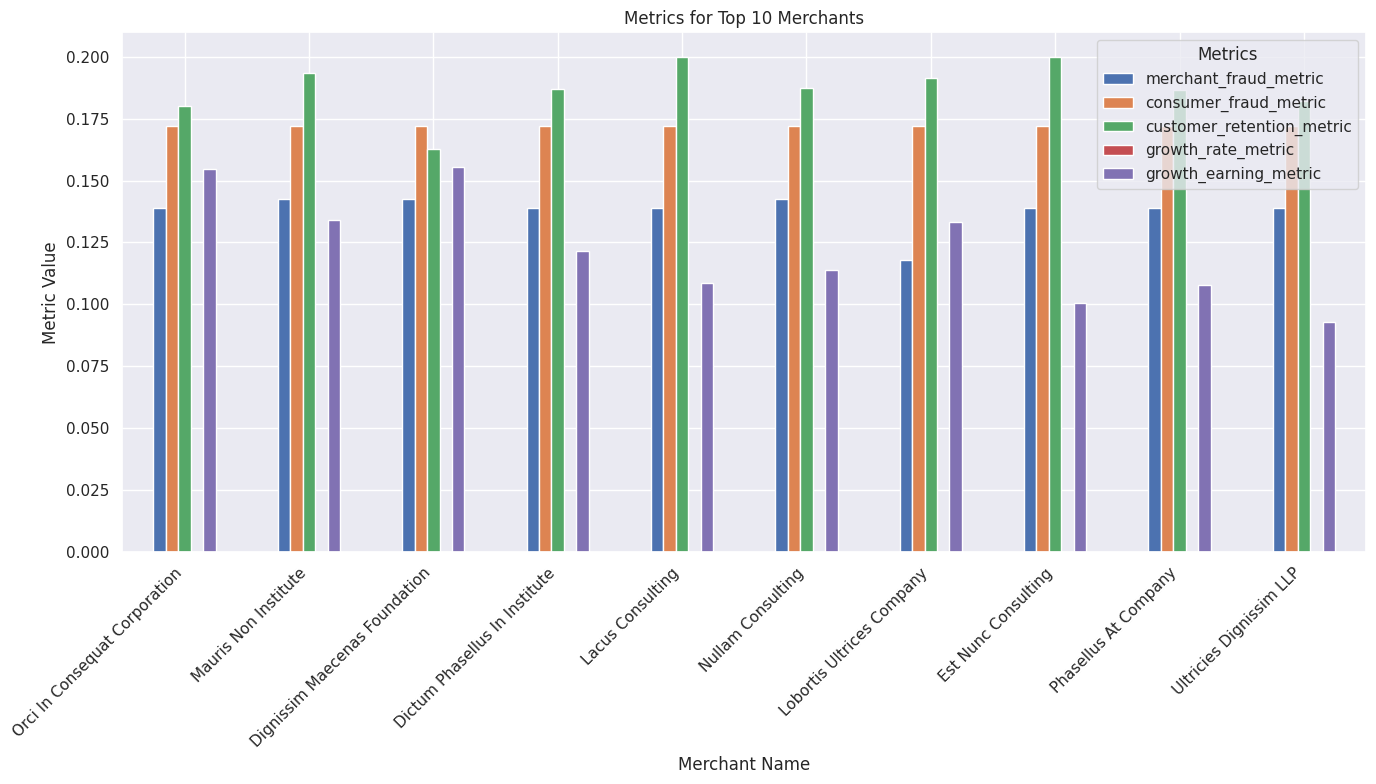

In [16]:
# Calculate the required metrics
top_10['merchant_fraud_metric'] = (1 - top_10['average_merchant_fraud'] / 100) / 5
top_10['consumer_fraud_metric'] = (1 - top_10['consumer_fraud_prediction'] / 100) / 5
top_10['customer_retention_metric'] = top_10['returning_customer_proportion'] / 5
top_10['growth_rate_metric'] = top_10['growth_rate_score'] / 5
top_10['growth_earning_metric'] = top_10['growth_dollars_score'] / 5

# Plot the metrics
metrics = ['merchant_fraud_metric', 'consumer_fraud_metric', 'customer_retention_metric', 'growth_rate_metric', 'growth_earning_metric']
top_10_metrics = top_10[['name'] + metrics].set_index('name')

top_10_metrics.plot(kind='bar', figsize=(14, 8))
plt.title('Metrics for Top 10 Merchants')
plt.ylabel('Metric Value')
plt.xlabel('Merchant Name')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.savefig("../plots/top_10_metrics.png")
plt.show()